In [1]:
import torch
import numpy as np
from torch_geometric.loader import DataLoader
from rdkit import Chem
from rdkit.Chem.rdmolops import AddHs
import os
import random

from torch_geometric.explain import Explainer, GNNExplainer, CaptumExplainer, PGExplainer

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, precision_score, recall_score, accuracy_score

import matplotlib.pyplot as plt
import plotly.graph_objects as go


import sys
from icecream import ic

sys.path.insert(0, 
                './Utils')


from Utils.plot_importances import *

from Utils.utils import *
from Utils.ploting_functions import *
from Utils.model import GCN_loop

In [2]:
random.seed(123456789)
outer = random.randint(1, 10)
inner = random.randint(1, 9)
print('Analysing outer {}, inner {}'.format(outer, inner))

Analysing outer 8, inner 9


In [3]:
current_dir = os.getcwd()
experiments_dir = 'RhCASA/GNN'

model_path = os.path.join(current_dir, experiments_dir, str(outer), '{}_{}_model'.format(outer,inner))

In [4]:
train_loader = torch.load(os.path.join(model_path, 'train_loader.pth'))
val_loader = torch.load(os.path.join(model_path, 'val_loader.pth'))
test_loader = torch.load(os.path.join(model_path, 'test_loader.pth'))

all_data = train_loader.dataset + val_loader.dataset + test_loader.dataset

loader_all = DataLoader(all_data)

Dataset type:  <class 'torch_geometric.data.data.Data'>
Dataset node features:  24
Dataset sample:  Data(x=[77, 24], edge_index=[2, 160], edge_attr=[160, 2], y=[1], category=[1], ligand='C1=C(c2ccccc2)[C@@H]2C=C(c3ccccc3)[C@H]1CC2', substrate='COC(=O)/C(C#N)=C/c1ccc(Cl)cc1', boron='OB(O)c1ccc(Br)cc1', ligand_num=17, ligand_id='L3.20', ligand_fam='fam3', idx=494, fold=7)
Sample features:  tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])
Sample outcome:  tensor([98.])
Sample cat:  tensor([1])


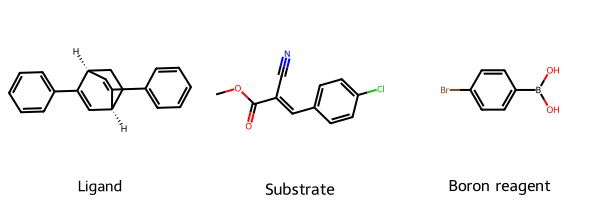

In [5]:
example_mol = test_loader.dataset[random.randint(0,len(test_loader.dataset))]

print("Dataset type: ", type(example_mol))
print("Dataset node features: ", example_mol.num_features)
print("Dataset sample: ", example_mol)
print('Sample features: ',  example_mol.x)
print('Sample outcome: ',  example_mol.y)
print('Sample cat: ',  example_mol.category)

ms = [example_mol.ligand, example_mol.substrate, example_mol.boron]
ms = [Chem.MolFromSmiles(mol) for mol in ms]
Chem.Draw.MolsToGridImage(ms,molsPerRow=3,subImgSize=(200,200),legends=['Ligand', 'Substrate', 'Boron reagent']) 

In [6]:
states = []
for outer in range(1,11):
    for inner in range(1,10):
        path = os.path.join(current_dir, experiments_dir, '{}'.format(outer), '{}_{}_model'.format(outer,inner), 'GNN_params_r.pth')
        params = torch.load(path, map_location=torch.device('cpu'))
        states.append(params)


avg_state = average_state_dicts(states)

In [7]:
device = 'cpu'
#model = torch.load(os.path.join(model_path, 'model_r.pth'))
model = GCN_loop(example_mol.num_features, embedding_size = 64, gnn_layers=2, improved=False)
model_params = torch.load(os.path.join(model_path, 'GNN_params_r.pth'))
model.load_state_dict(model_params)

model.to(device)

GCN_loop(
  (initial_conv): GCNConv(24, 64)
  (conv_layers): ModuleList(
    (0): GCNConv(64, 64)
  )
  (readout1): Linear(in_features=128, out_features=64, bias=True)
  (readout2): Linear(in_features=64, out_features=1, bias=True)
)

In [8]:
with torch.no_grad():

    predictions = []
    y = []
    indexes = []

    for batch in loader_all:

        batch.to(device)

        out = model(batch.x,
                    batch.edge_index,
                    batch.batch)
            
        predictions.append(out.cpu().detach().numpy())
        y.append(batch.y.cpu().detach().numpy())
        indexes.append(batch.idx.cpu().detach().numpy())

    predictions = np.concatenate(predictions).ravel()
    y = np.concatenate(y).ravel()
    indexes = np.concatenate(indexes).ravel()


df = pd.DataFrame({'real_top': y, 'predicted_top': predictions, 'Index': indexes})

df['real_side'] = np.where(df['real_top'] >50, 1, 0)
df['predicted_side'] = np.where(df['predicted_top'] >50, 1, 0)

accuracy = accuracy_score(df['real_side'], df['predicted_side'])
precision = precision_score(df['real_side'], df['predicted_side'])
recall = recall_score(df['real_side'], df['predicted_side'])

r2 = r2_score(df['real_side'], df['predicted_side'])
mae = mean_absolute_error(df['real_side'], df['predicted_side'])
rmse = sqrt(mean_squared_error(df['real_side'], df['predicted_side']))

print('Metrics of mean model over all datapoints')

print('Precision {}'.format(precision))
print('Recall {}'.format(recall))
print('Accuracy {}'.format(accuracy))
print('R2 {}'.format(r2))
print('MAE {}'.format(mae))
print('RMSE {}'.format(rmse))


Metrics of mean model over all datapoints
Precision 0.9853372434017595
Recall 0.9795918367346939
Accuracy 0.9825072886297376
R2 0.9300291545189504
MAE 0.01749271137026239
RMSE 0.13226001425322165


In [9]:
fig = go.Figure(data=go.Scatter(
    x = df['real_top'],
    y = df['predicted_top'],
    mode = 'markers',
    hovertext = df['Index']  # this line adds the index as hover text
))

fig.show()

In [10]:
feat_labels = ['Atomic number', 'Atom degree', 'Atom hybridization', 'Aromaticity', 'Atom in ring', 'Atom chirality', 'Molecule configuration']

In [11]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
)

In [12]:
loader = DataLoader(test_loader.dataset)
graph = next(iter(loader))

In [13]:
explanation = explainer(x = graph.x, edge_index=graph.edge_index,  batch_index=graph.batch)

In [14]:
ligand_masks, substrate_masks, boron_masks, all_masks  = explain_dataset(test_loader.dataset, explainer, mol = 'ligand')

100%|██████████| 68/68 [00:06<00:00, 10.79it/s]


In [15]:
all = visualize_score_features(score = all_masks)
all

,score,labels
Atom Degree,2936.027,Atom Degree
Atom Hybridization,2900.649,Atom Hybridization
Atom Identity,2892.616,Atom Identity
Atom Chirality,2863.689,Atom Chirality
System Configuration,1588.874,System Configuration
Atom InRing,970.647,Atom InRing
Atom Aromaticity,597.268,Atom Aromaticity


In [16]:
ligands = visualize_score_features(score = ligand_masks)
ligands = ligands.loc[ligands['score'] != 0]
ligands['labels'] = ligands['labels'].apply(lambda m: 'L. '+m)
ligands

,score,labels
Atom Degree,1529.308,L. Atom Degree
Atom Identity,1510.448,L. Atom Identity
Atom Hybridization,1503.827,L. Atom Hybridization
Atom Chirality,1485.783,L. Atom Chirality
System Configuration,841.835,L. System Configuration
Atom InRing,564.379,L. Atom InRing
Atom Aromaticity,297.697,L. Atom Aromaticity


In [17]:
substrate = visualize_score_features(score = substrate_masks)
substrate = substrate.loc[substrate['score'] != 0]
substrate['labels'] = substrate['labels'].apply(lambda m: 'S. '+m)
substrate

,score,labels
Atom Hybridization,764.628,S. Atom Hybridization
Atom Identity,760.119,S. Atom Identity
Atom Degree,756.051,S. Atom Degree
Atom Chirality,748.978,S. Atom Chirality
System Configuration,408.505,S. System Configuration
Atom InRing,165.758,S. Atom InRing
Atom Aromaticity,72.039,S. Atom Aromaticity


In [18]:
boron = visualize_score_features(score = boron_masks)
boron = boron.loc[boron['score'] != 0]
boron['labels'] = boron['labels'].apply(lambda m: 'BR. '+m)
boron

,score,labels
Atom Degree,650.671,BR. Atom Degree
Atom Hybridization,632.196,BR. Atom Hybridization
Atom Chirality,628.928,BR. Atom Chirality
Atom Identity,622.045,BR. Atom Identity
System Configuration,338.534,BR. System Configuration
Atom InRing,240.509,BR. Atom InRing
Atom Aromaticity,227.531,BR. Atom Aromaticity


In [19]:
df = pd.concat([ligands, substrate, boron])
df = df.sort_values('score', ascending=False)
df['score'] = df['score'].astype(int)

In [20]:
df

,score,labels
Atom Degree,1529,L. Atom Degree
Atom Identity,1510,L. Atom Identity
Atom Hybridization,1503,L. Atom Hybridization
Atom Chirality,1485,L. Atom Chirality
System Configuration,841,L. System Configuration
Atom Hybridization,764,S. Atom Hybridization
Atom Identity,760,S. Atom Identity
Atom Degree,756,S. Atom Degree
Atom Chirality,748,S. Atom Chirality
Atom Degree,650,BR. Atom Degree


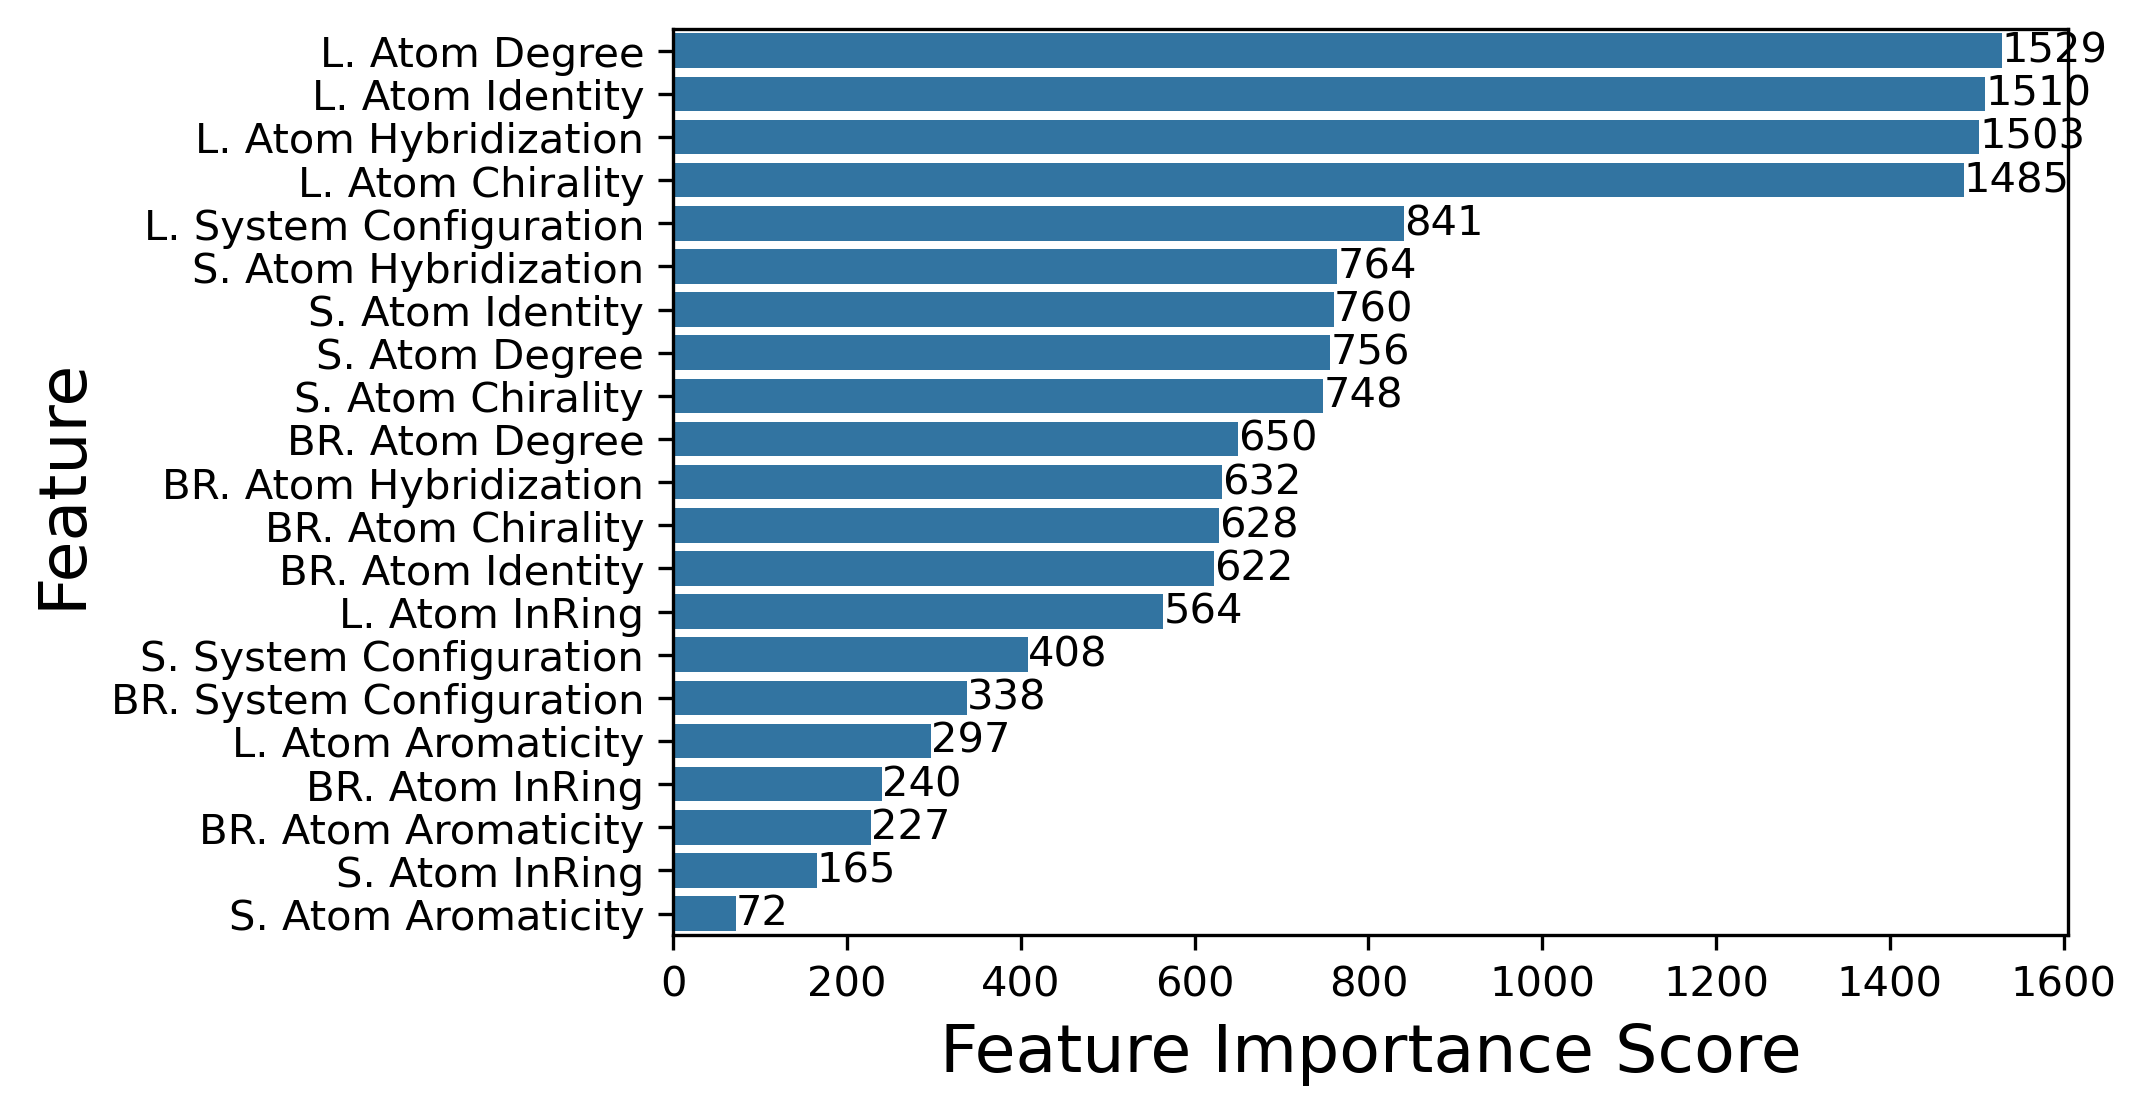

In [21]:
plt.figure(dpi=300)

ax = sns.barplot(df, x="score", y="labels", estimator="sum", errorbar=None)
ax.bar_label(ax.containers[0], fontsize=10)
#ax.set_yticklabels(ax.get_yticklabels(), verticalalignment='center', horizontalalignment='right')

plt.xlabel('Feature Importance Score', fontsize=16)
plt.ylabel('Feature', fontsize=16)

plt.show()

In [21]:
explainer = Explainer(
    model=model,
    algorithm=CaptumExplainer('ShapleyValueSampling'),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),
)

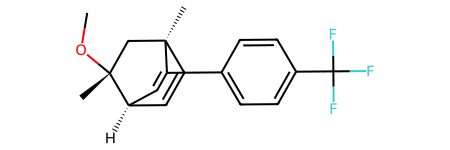

In [22]:
loader = DataLoader(loader_all.dataset)
molecule = get_graph_by_idx(loader, 98)
Chem.MolFromSmiles(molecule.ligand[0])

In [23]:
molecule.y

tensor([92.5000])

In [24]:
model(x = molecule.x, edge_index=molecule.edge_index,  batch_index=molecule.batch)

tensor([[90.9657]], grad_fn=<MulBackward0>)

In [25]:
explanation = explainer(x = molecule.x, edge_index=molecule.edge_index,  batch_index=molecule.batch)

In [26]:
plot_molecule_importance(mol_graph=molecule, mol='l', explanation=explanation, palette='normal')